<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone: Credit Card Recommender

---
## Problem Statement
You've want to sign up for a credit card that best fits you, but you've realised that you will need to comb through all card descriptions, conditions and reviews in order to decide which card is the best. You find that it is very inconvenient and as a data scientist, you decide to take it upon yourself to build a credit card recommender.

Use different techniques to analyse the reviews, credit card conditions to derive a credit card recommender that could help to save a lot of time when choosing a credit card.

### Contents:
- [Background](#Background)
- [Datasets Used](#Datasets-Used)
- [Extraction of Data](#Extraction-of-Data)
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Data Dictionary](#Data-Dictionary)
- [Pre-processing text data](#Pre-processing-text-data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Sentiment Analysis Using BERT](#Sentiment-Analysis-Using-BERT)

## Background

All credit cards in Singapore offer some sort of reward for using them for your purchases, which include incentives like cashback, reward points (which can be traded for air miles, discount vouchers or actual products), or airline miles. However, the most common reward, and perhaps the most enticing, would perhaps be cashback.

For the uninitiated, cashback refers to receiving back a percentage of what you spend in the form of money. It is akin to getting a perpetual discount whenever you spend. Sounds too good to be true? It really is not. Credit card companies are constantly competing to provide the most competitive rewards for their customers - some cards offer lucrative sign-up promotions, while others offer higher cashbacks for niche spending categories like travel or sustainability.

With so many cards available on the market to choose from, it is no wonder that Singaporeans have a hard time deciding which is the best credit card in Singapore. In particular, it is hard to compare the different cashback rewards across multiple categories for various credit cards. [(source)](https://sg.news.yahoo.com/three-reasons-why-own-credit-104237659.html)

## Datasets Used

Data in this used in the analysis consists of credit card details and reviews scrapped from various websites. Please rerefer to the data dictionary for more information on the columns extracted.

## Extraction of Data

Please refer to "**1. Extraction of Data**" for the steps done for data extraction.

## Data Import and Cleaning

**1. Importing of libraries**

In [1]:
# Import libraries
import pandas as pd
import string
import re
import nltk
import numpy as np
import pandas as pd
import sklearn

# Chart plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

# Modelling libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

**2. Importing of datasets being used**

We have imported the scraped_reviews dataset which we have extracted in "**1. Extraction of Data**".

In [2]:
# Import dataset:
file_path = 'all_credit_card_reviews_sentiment.xlsx'
credit_reviews_df = pd.read_excel(file_path)

**3. Display datasets**

In [3]:
# Display the first few rows of the dataset
print("First few rows of the dataset:")
display(credit_reviews_df.head())

First few rows of the dataset:


,Card,Review,Review_cleaned,Sentiment,Sentiment_Classification
0,UOB One Card,I have had my own story of crypto scams due to...,i have had my own story of crypto scams due to...,0.153355,Positive
1,UOB One Card,Good credit card to provide higher interest ra...,good credit card to provide higher interest ra...,0.521429,Positive
2,UOB One Card,Applied for this card years back along with on...,applied for this card years back along with on...,0.308333,Positive
3,UOB One Card,Pair up this card with the UOB ONE Savings acc...,pair up this card with the uob one savings acc...,0.179111,Positive
4,UOB One Card,The longest CC I have. It is a great card to u...,the longest cc i have. it is a great card to u...,0.750000,Positive


**4. Combine both datasets**

Combine both the card types dataset and reviews dataset into one single dataset.

In [4]:
# Display the columns in the dataset
print("Columns in the dataset:")
print(credit_reviews_df.columns)

Columns in the dataset:
Index(['Card', 'Review', 'Review_cleaned', 'Sentiment',
       'Sentiment_Classification'],
      dtype='object')


In [5]:
# Show the shape of the dataset (rows, columns)
print(f'Total Rows, Columns: {credit_reviews_df.shape}')

Total Rows, Columns: (427, 5)


**5. Remove '\n' from the reviews column**

'\n' is being used in html to denote new paragraphs. Thus, we will have to remove them from the `reviews` column before we proceed with preprocessing.

In [6]:
# Definisikan fungsi untuk menghapus karakter newline '\n'
def remove_newline(text):
    tokens = re.split(r'\n', text)  # Pisahkan berdasarkan '\n'
    my_string = ' '.join(tokens)  # Gabungkan kembali tanpa newline
    return my_string

# Terapkan fungsi pada kolom Review_cleaned
credit_reviews_df['Review_cleaned'] = credit_reviews_df['Review_cleaned'].apply(remove_newline)

# Tampilkan dataset setelah perubahan
display(credit_reviews_df.head())


,Card,Review,Review_cleaned,Sentiment,Sentiment_Classification
0,UOB One Card,I have had my own story of crypto scams due to...,i have had my own story of crypto scams due to...,0.153355,Positive
1,UOB One Card,Good credit card to provide higher interest ra...,good credit card to provide higher interest ra...,0.521429,Positive
2,UOB One Card,Applied for this card years back along with on...,applied for this card years back along with on...,0.308333,Positive
3,UOB One Card,Pair up this card with the UOB ONE Savings acc...,pair up this card with the uob one savings acc...,0.179111,Positive
4,UOB One Card,The longest CC I have. It is a great card to u...,the longest cc i have. it is a great card to u...,0.750000,Positive


**6. Split the dataset into cashback and miles card type**

We will split the dataset into cashback and air miles so that we can perfom the analysis on the two different types of cards.

In [53]:
# Create a new column 'card_type' to classify the card types
credit_reviews_df['card_type'] = credit_reviews_df['Card'].apply(
    lambda x: 'Cashback' if 'UOB One' in x or 'HSBC Revolution' in x or "UOB Ladys Card" in x else
    'Air Miles' if 'Citi PremierMiles' in x or 'DBS Altitude' in x or "UOB Ladys Card" in x or 'HSBC Revolution' in x else
    'Other'

)

# Filter for Cashback cards
cashback_expand_df = credit_reviews_df[credit_reviews_df['card_type'] == 'Cashback']
print(f'Cashback cards:')
display(cashback_expand_df.head())

# Show the total number of rows and columns in the cashback dataset
print(f'Rows, Columns: {cashback_expand_df.shape}')
print("\n")

# Filter for Air Miles cards
miles_expand_df = credit_reviews_df[credit_reviews_df['card_type'] == 'Air Miles']
print(f'Air Miles cards:')
display(miles_expand_df.head())

# Show the total number of rows and columns in the Air Miles dataset
print(f'Rows, Columns: {miles_expand_df.shape}')


Cashback cards:


,Card,Review,Review_cleaned,Sentiment,Sentiment_Classification,card_type,Review_tokenized,Review_no_stop,Review_lemmatized
0,UOB One Card,I have had my own story of crypto scams due to...,i have had my own story of crypto scams due to...,0.153355,Positive,Cashback,"[i, have, had, my, own, story, of, crypto, sca...","[story, crypto, scams, due, referrals, site, l...","[story, crypto, scam, due, referral, site, los..."
1,UOB One Card,Good credit card to provide higher interest ra...,good credit card to provide higher interest ra...,0.521429,Positive,Cashback,"[good, credit, card, to, provide, higher, inte...","[good, credit, card, provide, higher, interest...","[good, credit, card, provide, higher, interest..."
2,UOB One Card,Applied for this card years back along with on...,applied for this card years back along with on...,0.308333,Positive,Cashback,"[applied, for, this, card, years, back, along,...","[applied, card, years, back, along, one, accou...","[applied, card, year, back, along, one, accoun..."
3,UOB One Card,Pair up this card with the UOB ONE Savings acc...,pair up this card with the uob one savings acc...,0.179111,Positive,Cashback,"[pair, up, this, card, with, the, uob, one, sa...","[pair, card, uob, one, savings, account, maxim...","[pair, card, uob, one, saving, account, maximi..."
4,UOB One Card,The longest CC I have. It is a great card to u...,the longest cc i have it is a great card to us...,0.750000,Positive,Cashback,"[the, longest, cc, i, have, it, is, a, great, ...","[longest, cc, great, card, use, use, min, 2k, ...","[longest, cc, great, card, use, use, min, 2k, ..."


Rows, Columns: (244, 9)


Air Miles cards:


,Card,Review,Review_cleaned,Sentiment,Sentiment_Classification,card_type,Review_tokenized,Review_no_stop,Review_lemmatized
171,Citi PremierMiles Visa Card,[Fee Waivers]\nAnnual fee waiver was almost au...,fee waivers annual fee waiver was almost autom...,0.109375,Positive,Air Miles,"[fee, waivers, annual, fee, waiver, was, almos...","[fee, waivers, annual, fee, waiver, almost, au...","[fee, waiver, annual, fee, waiver, almost, aut..."
172,Citi PremierMiles Visa Card,Although the fee waiver could actually be done...,although the fee waiver could actually be done...,0.277778,Positive,Air Miles,"[although, the, fee, waiver, could, actually, ...","[although, fee, waiver, could, actually, done,...","[although, fee, waiver, could, actually, done,..."
173,Citi PremierMiles Visa Card,This is a good credit card for overseas travel...,this is a good credit card for overseas travel...,0.537500,Positive,Air Miles,"[this, is, a, good, credit, card, for, oversea...","[good, credit, card, overseas, travelling, iss...","[good, credit, card, overseas, travelling, iss..."
174,Citi PremierMiles Visa Card,Good promotions and very easy to access my rew...,good promotions and very easy to access my rew...,0.565556,Positive,Air Miles,"[good, promotions, and, very, easy, to, access...","[good, promotions, easy, access, rewards, when...","[good, promotion, easy, access, reward, whenev..."
175,Citi PremierMiles Visa Card,[Promotions and Perks]\nMiles never expires. T...,promotions and perks miles never expires they ...,0.325000,Positive,Air Miles,"[promotions, and, perks, miles, never, expires...","[promotions, perks, miles, never, expires, att...","[promotion, perk, mile, never, expires, attain..."


Rows, Columns: (183, 9)


Now that the cleaning portion is done, we will perform some pre-processing to prepare the data for analysis.

## Data Dictionary

<br>**Dataset name: `cashback_expand_df`**
<br>This dataset contains all the reviews on cashback credit cards.

| Feature | Type | Dataset | Description |
|:--|:-:|:-:|:--|
|credit_card_name|string|perfumes_df|Name of the credit card.|
|card_type|string|perfumes_df|Type of credit card. Cashback of Air Miles.|
|reviews|string|perfumes_df|Reviews on the credit cards.|


<br>**Dataset name: `miles_expand_df`**
<br>This dataset contains all the reviews on air miles credit cards.

| Feature | Type | Dataset | Description |
|:--|:-:|:-:|:--|
|credit_card_name|string|perfumes_df|Name of the credit card.|
|card_type|string|perfumes_df|Type of credit card. Cashback of Air Miles.|
|reviews|string|perfumes_df|Reviews on the credit cards.|

<br>**Dataset name: `combined_expand_df`**
<br>This dataset contains all the reviews on all credit cards.

| Feature | Type | Dataset | Description |
|:--|:-:|:-:|:--|
|credit_card_name|string|perfumes_df|Name of the credit card.|
|card_type|string|perfumes_df|Type of credit card. Cashback of Air Miles.|
|reviews|string|perfumes_df|Reviews on the credit cards.|

## Pre-processing text data

Now we will clean the text data so that we can perform analysis on the datasets.

**1. Remove punctuations**

Remove the punctuations as these are not required in text analysis.

In [54]:
import string

# Define function to remove punctuation
def remove_punct(text):
    return "".join([char for char in text if char not in string.punctuation])

# Apply the function to the 'Review_cleaned' column
credit_reviews_df['Review_cleaned'] = credit_reviews_df['Review_cleaned'].apply(remove_punct)

# Display the dataset after the changes
display(credit_reviews_df.head())


,Card,Review,Review_cleaned,Sentiment,Sentiment_Classification,card_type,Review_tokenized,Review_no_stop,Review_lemmatized
0,UOB One Card,I have had my own story of crypto scams due to...,i have had my own story of crypto scams due to...,0.153355,Positive,Cashback,"[i, have, had, my, own, story, of, crypto, sca...","[story, crypto, scams, due, referrals, site, l...","[story, crypto, scam, due, referral, site, los..."
1,UOB One Card,Good credit card to provide higher interest ra...,good credit card to provide higher interest ra...,0.521429,Positive,Cashback,"[good, credit, card, to, provide, higher, inte...","[good, credit, card, provide, higher, interest...","[good, credit, card, provide, higher, interest..."
2,UOB One Card,Applied for this card years back along with on...,applied for this card years back along with on...,0.308333,Positive,Cashback,"[applied, for, this, card, years, back, along,...","[applied, card, years, back, along, one, accou...","[applied, card, year, back, along, one, accoun..."
3,UOB One Card,Pair up this card with the UOB ONE Savings acc...,pair up this card with the uob one savings acc...,0.179111,Positive,Cashback,"[pair, up, this, card, with, the, uob, one, sa...","[pair, card, uob, one, savings, account, maxim...","[pair, card, uob, one, saving, account, maximi..."
4,UOB One Card,The longest CC I have. It is a great card to u...,the longest cc i have it is a great card to us...,0.750000,Positive,Cashback,"[the, longest, cc, i, have, it, is, a, great, ...","[longest, cc, great, card, use, use, min, 2k, ...","[longest, cc, great, card, use, use, min, 2k, ..."


**2. Tokenization**

Split the text into smaller pieces, ie. single words.

In [55]:
import re

# Define function to tokenize the column
def tokenize(text):
    return re.split('\W+', text.lower())

# Apply the tokenization function to the 'Review_cleaned' column
credit_reviews_df['Review_tokenized'] = credit_reviews_df['Review_cleaned'].apply(tokenize)

# Display the dataset after the changes
display(credit_reviews_df.head())


,Card,Review,Review_cleaned,Sentiment,Sentiment_Classification,card_type,Review_tokenized,Review_no_stop,Review_lemmatized
0,UOB One Card,I have had my own story of crypto scams due to...,i have had my own story of crypto scams due to...,0.153355,Positive,Cashback,"[i, have, had, my, own, story, of, crypto, sca...","[story, crypto, scams, due, referrals, site, l...","[story, crypto, scam, due, referral, site, los..."
1,UOB One Card,Good credit card to provide higher interest ra...,good credit card to provide higher interest ra...,0.521429,Positive,Cashback,"[good, credit, card, to, provide, higher, inte...","[good, credit, card, provide, higher, interest...","[good, credit, card, provide, higher, interest..."
2,UOB One Card,Applied for this card years back along with on...,applied for this card years back along with on...,0.308333,Positive,Cashback,"[applied, for, this, card, years, back, along,...","[applied, card, years, back, along, one, accou...","[applied, card, year, back, along, one, accoun..."
3,UOB One Card,Pair up this card with the UOB ONE Savings acc...,pair up this card with the uob one savings acc...,0.179111,Positive,Cashback,"[pair, up, this, card, with, the, uob, one, sa...","[pair, card, uob, one, savings, account, maxim...","[pair, card, uob, one, saving, account, maximi..."
4,UOB One Card,The longest CC I have. It is a great card to u...,the longest cc i have it is a great card to us...,0.750000,Positive,Cashback,"[the, longest, cc, i, have, it, is, a, great, ...","[longest, cc, great, card, use, use, min, 2k, ...","[longest, cc, great, card, use, use, min, 2k, ..."


**3. Remove stopwords**

Remove the words that have very little meaning as these words are not going to be helpful in our analysis.

In [57]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get the list of stopwords from NLTK
stopword = stopwords.words('english')

# Define function to remove stopwords
def remove_stopwords(tokenized_list):
    return [word for word in tokenized_list if word not in stopword]

# Apply the function to remove stopwords from the 'Review_tokenized' column
credit_reviews_df['Review_no_stop'] = credit_reviews_df['Review_tokenized'].apply(remove_stopwords)

# Display the dataset after the changes
display(credit_reviews_df.head())


[nltk_data] Downloading package stopwords to C:\Users\ANGGIAT PANDU
[nltk_data]     DS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Card,Review,Review_cleaned,Sentiment,Sentiment_Classification,card_type,Review_tokenized,Review_no_stop,Review_lemmatized
0,UOB One Card,I have had my own story of crypto scams due to...,i have had my own story of crypto scams due to...,0.153355,Positive,Cashback,"[i, have, had, my, own, story, of, crypto, sca...","[story, crypto, scams, due, referrals, site, l...","[story, crypto, scam, due, referral, site, los..."
1,UOB One Card,Good credit card to provide higher interest ra...,good credit card to provide higher interest ra...,0.521429,Positive,Cashback,"[good, credit, card, to, provide, higher, inte...","[good, credit, card, provide, higher, interest...","[good, credit, card, provide, higher, interest..."
2,UOB One Card,Applied for this card years back along with on...,applied for this card years back along with on...,0.308333,Positive,Cashback,"[applied, for, this, card, years, back, along,...","[applied, card, years, back, along, one, accou...","[applied, card, year, back, along, one, accoun..."
3,UOB One Card,Pair up this card with the UOB ONE Savings acc...,pair up this card with the uob one savings acc...,0.179111,Positive,Cashback,"[pair, up, this, card, with, the, uob, one, sa...","[pair, card, uob, one, savings, account, maxim...","[pair, card, uob, one, saving, account, maximi..."
4,UOB One Card,The longest CC I have. It is a great card to u...,the longest cc i have it is a great card to us...,0.750000,Positive,Cashback,"[the, longest, cc, i, have, it, is, a, great, ...","[longest, cc, great, card, use, use, min, 2k, ...","[longest, cc, great, card, use, use, min, 2k, ..."


**4. Lemmatization**

Convert the words into their most basic forms for analysis.

In [58]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# Create a WordNet lemmatizer instance
wn = WordNetLemmatizer()

# Define function for lemmatization
def lemmatizing(tokenized_text):
    return [wn.lemmatize(word) for word in tokenized_text]

# Apply lemmatization to the 'Review_no_stop' column
credit_reviews_df['Review_lemmatized'] = credit_reviews_df['Review_no_stop'].apply(lemmatizing)

# Display the dataset after the changes
display(credit_reviews_df.head())


[nltk_data] Downloading package wordnet to C:\Users\ANGGIAT PANDU
[nltk_data]     DS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Card,Review,Review_cleaned,Sentiment,Sentiment_Classification,card_type,Review_tokenized,Review_no_stop,Review_lemmatized
0,UOB One Card,I have had my own story of crypto scams due to...,i have had my own story of crypto scams due to...,0.153355,Positive,Cashback,"[i, have, had, my, own, story, of, crypto, sca...","[story, crypto, scams, due, referrals, site, l...","[story, crypto, scam, due, referral, site, los..."
1,UOB One Card,Good credit card to provide higher interest ra...,good credit card to provide higher interest ra...,0.521429,Positive,Cashback,"[good, credit, card, to, provide, higher, inte...","[good, credit, card, provide, higher, interest...","[good, credit, card, provide, higher, interest..."
2,UOB One Card,Applied for this card years back along with on...,applied for this card years back along with on...,0.308333,Positive,Cashback,"[applied, for, this, card, years, back, along,...","[applied, card, years, back, along, one, accou...","[applied, card, year, back, along, one, accoun..."
3,UOB One Card,Pair up this card with the UOB ONE Savings acc...,pair up this card with the uob one savings acc...,0.179111,Positive,Cashback,"[pair, up, this, card, with, the, uob, one, sa...","[pair, card, uob, one, savings, account, maxim...","[pair, card, uob, one, saving, account, maximi..."
4,UOB One Card,The longest CC I have. It is a great card to u...,the longest cc i have it is a great card to us...,0.750000,Positive,Cashback,"[the, longest, cc, i, have, it, is, a, great, ...","[longest, cc, great, card, use, use, min, 2k, ...","[longest, cc, great, card, use, use, min, 2k, ..."


**5. Count Vectorizer**

Convert text data into a structured, numeric X dataframe by using CountVectorizer.

In [59]:
from sklearn.feature_extraction.text import CountVectorizer

# Define a function to check CountVectorizer output
def countvec_check(value):
    # Create an instance of CountVectorizer with lemmatizer as analyzer
    count_vect = CountVectorizer(analyzer=lambda x: x)
    X_counts = count_vect.fit_transform(value)

    # Display the shape of the vectorized data
    print(f'Rows, Columns: {X_counts.shape}')
    
    # Display the unique words across all text reviews
    print(count_vect.get_feature_names_out())

# Apply CountVectorizer to the 'Review_lemmatized' column
countvec_check(credit_reviews_df['Review_lemmatized'])


Rows, Columns: (427, 1941)
['' '0' '001' ... 'young' 'youre' 'zero']


Now we have a count matrix with 4,621 unique words. Now we are ready to do some Exploratory Data Analysis! Let's look at the top words found in each card type.

## Exploratory Data Analysis

**1. Most Common Two-Word and Three-Word phrases**

**1.1. Count Vectorizer (N-Grams for Cashback dataset)**

In [60]:
# Filter for Cashback cards
cashback_analyse_df = credit_reviews_df[credit_reviews_df['card_type'] == 'Cashback']

# Filter for Air Miles cards
miles_analyse_df = credit_reviews_df[credit_reviews_df['card_type'] == 'Air Miles']


In [61]:
# Import the necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Define function to find top words
def top_words(value, num):
    return value.sum().sort_values(ascending=False).head(num)

# Define function for N-Gram lemmatization
def lemmatizing_ngram(tokenized_text):
    text_list = []
    for word in tokenized_text:
        # Treat 'spending' as a verb instead of a noun
        if word.startswith('spend'):
            text_list.append(wn.lemmatize(word, nltk.corpus.wordnet.VERB))
        # Do not lemmatize the word dbs
        elif word.startswith('dbs'):
            text_list.append(word)
        else:
            text_list.append(wn.lemmatize(word))
    return ' '.join(text_list)

# Define function to create sparse matrix for N-Gram
def sparsematrix_ngram_check(value, num):
    # Create a n-gram (bi-gram or tri-gram based on 'num' parameter)
    ngram_vect = CountVectorizer(ngram_range=(num, num))

    # X_counts stores the vectorized version of the data
    X_counts = ngram_vect.fit_transform(value)

    # Expand sparse matrix to a DataFrame
    X_counts_df = pd.DataFrame(X_counts.toarray(), columns=ngram_vect.get_feature_names_out())

    return X_counts_df


There are a total of 17,169 unqiue two-word phrases in the Cashback dataset. Let's look at the top 20 phrases.

**Bigram - Cashback**

In [62]:
# Lemmatize the 'Review_lemmatized' column for Cashback dataset
cashback_analyse_df['reviews_lemmatized'] = cashback_analyse_df['Review_no_stop'].apply(
    lambda x: lemmatizing_ngram(x))

# Create a bigram sparse matrix for Cashback dataset
cashback_analyse_df_bigram = sparsematrix_ngram_check(cashback_analyse_df['reviews_lemmatized'], 2)

# Display the total number of rows and columns in the bigram matrix
print('Total number of rows and columns:')
print(f'(Rows, Columns): {cashback_analyse_df_bigram.shape}')

# Print top 20 BiGram words for Cashback dataset
print('Top 20 BiGram words for Cashback dataset')
print(top_words(cashback_analyse_df_bigram, 20).to_string())


Total number of rows and columns:
(Rows, Columns): (244, 4353)
Top 20 BiGram words for Cashback dataset
uob one             56
one account         40
cashback card       37
credit card         34
customer service    33
fee waiver          32
cash rebate         26
one card            23
minimum spend       22
cash back           19
per month           18
interest rate       17
annual fee          16
spend 500           16
mile card           15
great card          12
one best            11
min spend           11
saving account      11
promotion perk      10


Words such as "minimum spend", "customer service", "fee waiver", "promotion perk", and "annual fee" have appeared in the top 20 words. These words refer to the things that customers look out for when choosing credit cards. It seems like UOB One and DBS Everyday Cards are the most mentioned cards.

Now, lets take a look at the three-word phrases.

**Trigram - Cashback**

In [63]:
# Create a trigram sparse matrix for Cashback dataset
cashback_analyse_df_trigram = sparsematrix_ngram_check(cashback_analyse_df['reviews_lemmatized'], 3)

# Display the total number of rows and columns in the trigram matrix
print('Total number of rows and columns:')
print(f'(Rows, Columns): {cashback_analyse_df_trigram.shape}')

Total number of rows and columns:
(Rows, Columns): (244, 4995)


There are a total of 21,896 unqiue three-word phrases in the Cashback dataset. Let's look at the top 20 phrases.

In [64]:
# Print top 20 TriGram words for Cashback dataset
print('Top 20 TriGram words for Cashback dataset')
print(top_words(cashback_analyse_df_trigram, 20).to_string())

Top 20 TriGram words for Cashback dataset
uob one account         24
uob one card            17
one saving account       7
uob one saving           7
500 1000 2000            6
higher interest rate     6
best cash rebate         5
hit minimum spend        5
spend per month          5
per month get            5
best credit card         4
card uob one             4
rate bank account        4
mile per dollar          4
mile chaser wallet       4
credit card market       4
one best card            4
spend minimum 500        4
one card one             4
one account interest     4


In the top 20 three-word phrases, we also see words such as 'minimum spend required', 'cashback minimum spend' and 'minimimum spend 600'. It seems like customers are the most concerned about minimum spending requirements for the cards. The most mentioned cards here are the DBS and UOB cards, as they affect the interest rates of their savings accounts.

**1.2. Visualise our findings for Cashback dataset**

Now, let's visualise our findings from the Cashback dataset.

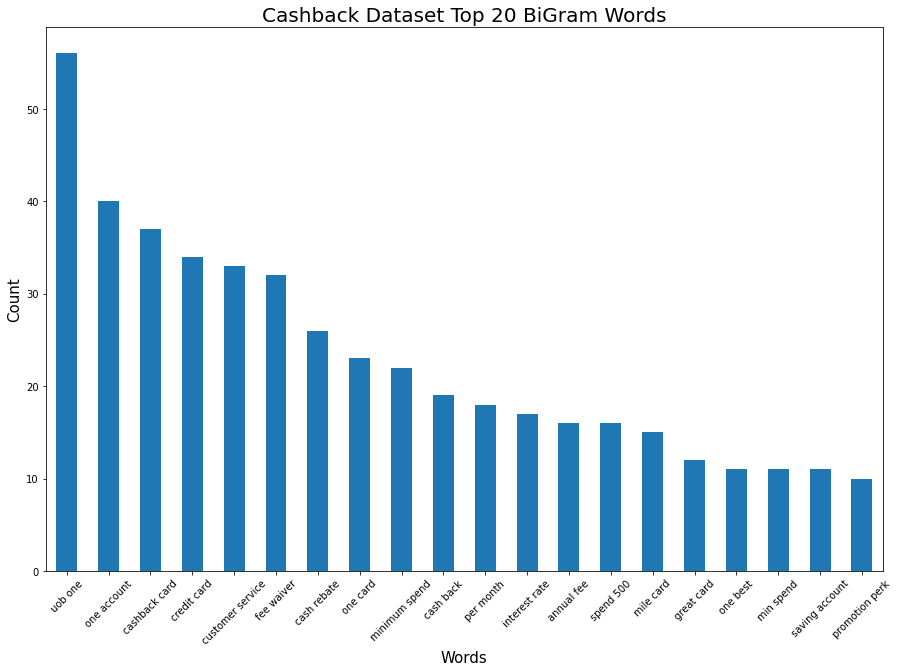

In [65]:
import matplotlib.pyplot as plt

# Convert the top word count for bigrams to a dataframe
top_words_cashback_bigram = top_words(cashback_analyse_df_bigram, 20).to_frame()

# Plot the top 20 bigram words in a bar chart
cashback_bigram = top_words_cashback_bigram.plot(kind='bar', figsize=(15, 10), fontsize=10, width=0.5)

# Set the title, x & y labels, and remove the legend
cashback_bigram.set_title('Cashback Dataset Top 20 BiGram Words', fontsize=20)
cashback_bigram.get_legend().remove()
cashback_bigram.set_ylabel('Count', fontsize=15)
cashback_bigram.set_xlabel('Words', fontsize=15)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


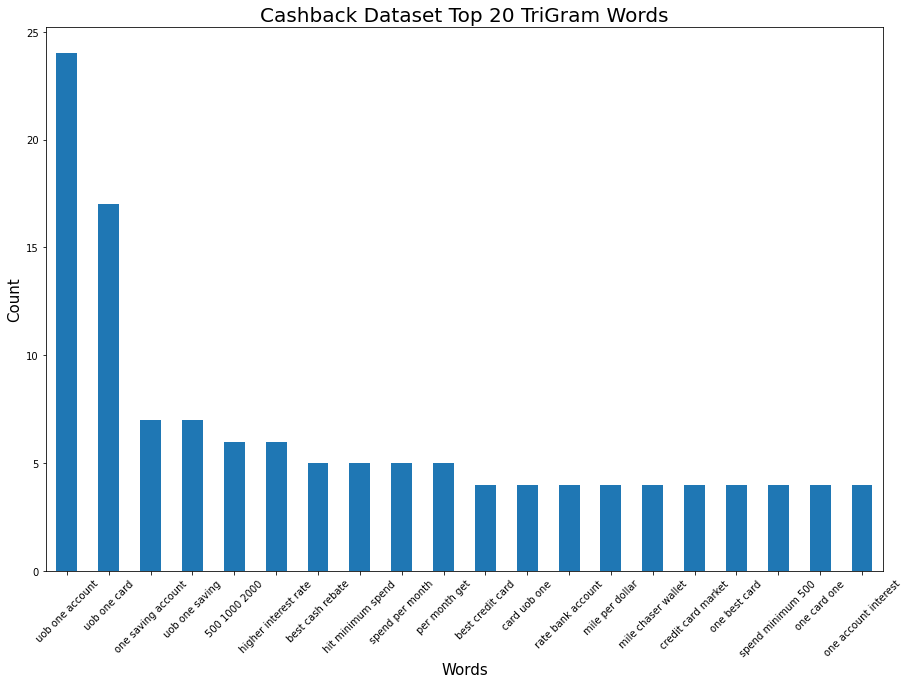

In [66]:
# Convert the top word count for trigrams to a dataframe
top_words_cashback_trigram = top_words(cashback_analyse_df_trigram, 20).to_frame()

# Plot the top 20 trigram words in a bar chart
cashback_trigram = top_words_cashback_trigram.plot(kind='bar', figsize=(15, 10), fontsize=10, width=0.5)

# Set the title, x & y labels, and remove the legend
cashback_trigram.set_title('Cashback Dataset Top 20 TriGram Words', fontsize=20)
cashback_trigram.get_legend().remove()
cashback_trigram.set_ylabel('Count', fontsize=15)
cashback_trigram.set_xlabel('Words', fontsize=15)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


Now, let's look at the top 20 two-word and three-word phrases for the Air Miles dataset.

**1.3. Count Vectorizer (N-Grams for Air Miles dataset)**

In [67]:
# Lemmatize the 'Review_no_stop' column for Air Miles dataset
miles_analyse_df['reviews_lemmatized'] = miles_analyse_df['Review_no_stop'].apply(
    lambda x: lemmatizing_ngram(x))

# Create bigram sparse matrix for Air Miles dataset
miles_analyse_df_bigram = sparsematrix_ngram_check(miles_analyse_df['reviews_lemmatized'], 2)

# Display the total number of rows and columns in the bigram matrix
print('Total number of rows and columns:')
print(f'(Rows, Columns): {miles_analyse_df_bigram.shape}')


Total number of rows and columns:
(Rows, Columns): (183, 3440)


There are a total of 6,559 unqiue two-word phrases in the Air Miles dataset. Let's look at the top 20 phrases.

**Bigram - Air Miles**

In [68]:
# Print top 20 BiGram words for Air Miles dataset
print('Top 20 BiGram words for Air Miles dataset')
print(top_words(miles_analyse_df_bigram, 20).to_string())

Top 20 BiGram words for Air Miles dataset
mile card           74
fee waiver          48
annual fee          33
credit card         31
mile expire         26
mile per            24
per dollar          23
customer service    21
priority pas        18
lounge access       17
dont expire         14
dbs point           14
airport lounge      14
using card          13
general spend       13
card mile           13
12 mile             12
promotion perk      11
never expire        10
dbs altitude        10


Similarly, words such as 'fee waiver', 'customer serivice', 'annual fees' and 'sign bonus' are among the top few words. These are some the things that customers look out for when signing new credit cards. Customers also look out how many miles they can get per dollar spent and how long it takes for their miles to expire. Once again, DBS cards can be found in the top 20 two-word prhases.

Now, lets take a look at the three-word phrases.

**Trigram - Air Miles**

In [69]:
# Create trigram sparse matrix for Air Miles dataset
miles_analyse_df_trigram = sparsematrix_ngram_check(miles_analyse_df['reviews_lemmatized'], 3)

# Display the total number of rows and columns in the trigram matrix
print('Total number of rows and columns:')
print(f'(Rows, Columns): {miles_analyse_df_trigram.shape}')

Total number of rows and columns:
(Rows, Columns): (183, 4047)


There are a total of 7,745 unqiue three-word phrases in the Air Miles dataset. Let's look at the top 20 phrases.

In [70]:
# Print top 20 TriGram words for Air Miles dataset
print('Top 20 TriGram words for Air Miles dataset')
print(top_words(miles_analyse_df_trigram, 20).to_string())

Top 20 TriGram words for Air Miles dataset
mile per dollar          20
annual fee waiver        10
airport lounge access     7
best mile card            7
12 mile per               6
mile never expire         5
point dont expire         5
waive annual fee          5
mile dont expire          5
general spend card        5
mile card good            5
point never expire        4
lounge access per         4
good credit card          4
like mile expire          4
promotion perk mile       4
mile card use             4
per dollar spent          4
entry level mile          4
pay annual fee            4


In the top 20 three-word phrases, we also see words such as 'waive annual fee', 'pay annual fee', 'miles dont expire', 'point dont expire', 'mile never expire'. It seems like customers are the most concerned about annual fee for the card and whether the files expired or not. The most mentioned cards here are the DBS cards.

**1.4. Visualise our findings for Air Miles dataset**

Now, let's visualise our findings from the Cashback dataset.

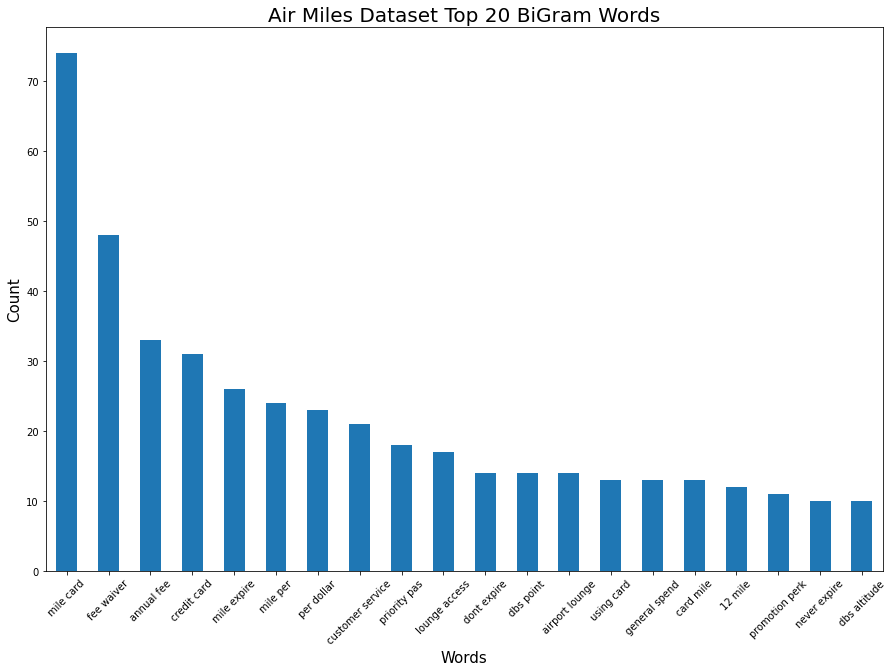

In [71]:
import matplotlib.pyplot as plt

# Convert the top word count for bigrams to a dataframe
top_words_miles_bigram = top_words(miles_analyse_df_bigram, 20).to_frame()

# Plot the top 20 bigram words in a bar chart
miles_bigram = top_words_miles_bigram.plot(kind='bar', figsize=(15, 10), fontsize=10, width=0.5)

# Set the title, x & y labels, and remove the legend
miles_bigram.set_title('Air Miles Dataset Top 20 BiGram Words', fontsize=20)
miles_bigram.get_legend().remove()
miles_bigram.set_ylabel('Count', fontsize=15)
miles_bigram.set_xlabel('Words', fontsize=15)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


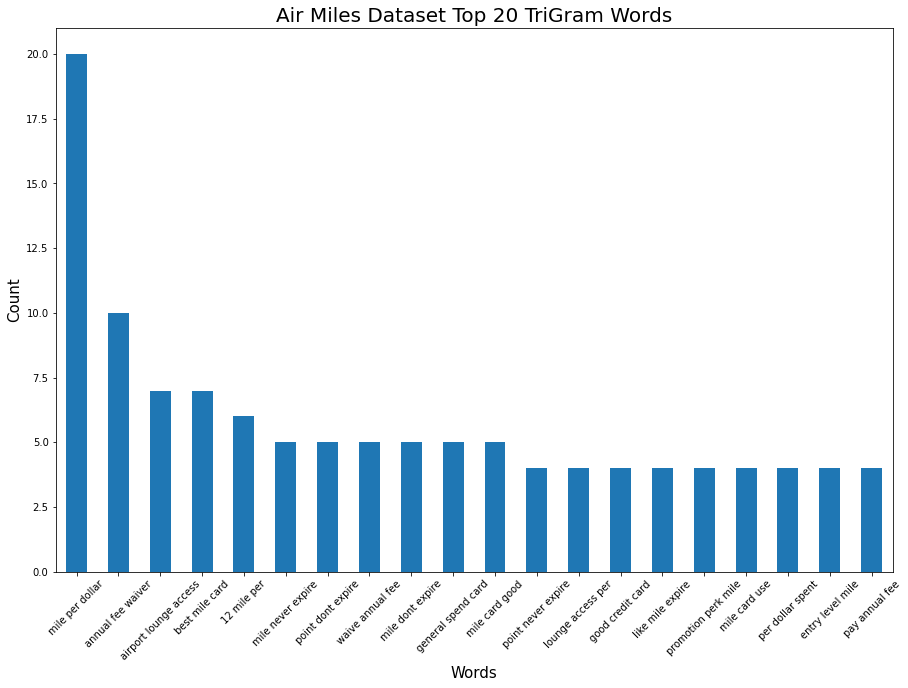

In [72]:
# Convert the top word count for trigrams to a dataframe
top_words_miles_trigram = top_words(miles_analyse_df_trigram, 20).to_frame()

# Plot the top 20 trigram words in a bar chart
miles_trigram = top_words_miles_trigram.plot(kind='bar', figsize=(15, 10), fontsize=10, width=0.5)

# Set the title, x & y labels, and remove the legend
miles_trigram.set_title('Air Miles Dataset Top 20 TriGram Words', fontsize=20)
miles_trigram.get_legend().remove()
miles_trigram.set_ylabel('Count', fontsize=15)
miles_trigram.set_xlabel('Words', fontsize=15)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


Now that we have taken took at the two-Words and three-Words phrases, let's gather some insights by taking a look at the most common words.

**2. Most Common Words**

Let's find the top 20 words for each subreddit.

**2.1. Most Common Words in Cashback dataset**

In [73]:
# Define function to remove stopwords
def remove_stopwords(tokenized_list):
    stopword_list = set(stopwords.words('english'))
    return [word for word in tokenized_list if word not in stopword_list]

# Define lemmatization function
def lemmatizing_ngram(tokenized_text):
    return [wn.lemmatize(word) for word in tokenized_text]

# Define function for sparse matrix
def sparsematrix_check(value):
    # Create an instance of CountVectorizer
    count_vect = CountVectorizer()

    # X_counts stores the vectorized version of the data
    X_counts = count_vect.fit_transform(value)
    
    # Expand sparse matrix to a collection of arrays and then store it in a DataFrame
    X_counts_df = pd.DataFrame(X_counts.toarray())
    
    # Apply column names to the dataframe
    X_counts_df.columns = count_vect.get_feature_names_out()
    
    return X_counts_df

# Assume cashback_analyse_df and miles_analyse_df already have 'Review_cleaned' column

# Apply tokenization and remove stopwords for Cashback dataset
cashback_analyse_df['reviews_tokenized'] = cashback_analyse_df['Review_cleaned'].apply(lambda x: x.split())
cashback_analyse_df['reviews_no_stop'] = cashback_analyse_df['reviews_tokenized'].apply(remove_stopwords)

# Apply tokenization and remove stopwords for Air Miles dataset
miles_analyse_df['reviews_tokenized'] = miles_analyse_df['Review_cleaned'].apply(lambda x: x.split())
miles_analyse_df['reviews_no_stop'] = miles_analyse_df['reviews_tokenized'].apply(remove_stopwords)

# Apply lemmatizing to 'reviews_no_stop' for Cashback dataset
cashback_analyse_df['reviews_lemmatized'] = cashback_analyse_df['reviews_no_stop'].apply(lemmatizing_ngram)

# Apply lemmatizing to 'reviews_no_stop' for Air Miles dataset
miles_analyse_df['reviews_lemmatized'] = miles_analyse_df['reviews_no_stop'].apply(lemmatizing_ngram)

# Join the lemmatized tokens into strings for CountVectorizer
cashback_analyse_df['reviews_string'] = cashback_analyse_df['reviews_lemmatized'].apply(lambda x: ' '.join(x))
miles_analyse_df['reviews_string'] = miles_analyse_df['reviews_lemmatized'].apply(lambda x: ' '.join(x))

# Create sparse matrix for Cashback dataset
cashback_sparse_matrix = sparsematrix_check(cashback_analyse_df['reviews_string'])

# Create sparse matrix for Air Miles dataset
miles_sparse_matrix = sparsematrix_check(miles_analyse_df['reviews_string'])

In [74]:
# Define function to find top words
def top_words(value, num):
    return value.sum().sort_values(ascending = False).head(num)

# Find the top 50 words in Cashback dataset
print('Top 50 words in Cashback dataset:')
print("")
print(top_words(cashback_sparse_matrix, 50).to_string())

Top 50 words in Cashback dataset:

card           355
cashback       128
one            124
uob             99
month           98
rebate          82
spending        79
spend           79
account         72
get             66
fee             58
good            57
use             55
cash            55
500             49
mile            47
customer        45
service         43
credit          42
interest        39
minimum         38
waiver          37
back            36
reward          34
best            34
transaction     34
hit             33
monthly         33
great           33
using           31
year            30
per             30
easy            28
need            27
time            27
quarter         26
bill            26
min             25
used            25
hsbc            24
grab            24
also            24
point           23
every           23
useful          23
tier            23
quarterly       22
first           22
rate            22
payment         21


Noted that there are further stopwords like spaces, '5', '15', '3', '1' etc that doesn't really make sense. As such we will remove these words from the `cashback_analyse_df` dataset. 

From the top 50 words, we will try to identify and remove as many stop words as possible. After that, we will look at the revised top 20 words to make sure that all of the stopwords have been removed from the list.

**2.2. Remove Further Stopwords from the Cashback Dataset**

In [75]:
# Define function to remove further stop words
def remove_further_stopwords(tokenized_list, stopword_list):
    # Remove stopwords from the list of tokens
    return [word for word in tokenized_list if word not in stopword_list]

# List of additional stopwords to remove
stopwords_cashback = ['', '5', '1', '3', '15', 'use', 'get', 'one', 'card', 'back', 'good', 'using', 'also', 'like']

# Remove stopwords from 'reviews_no_stop' column for Cashback dataset
cashback_analyse_df['reviews_no_stop_further'] = cashback_analyse_df['reviews_no_stop'].apply(
    lambda x: remove_further_stopwords(x, stopwords_cashback))

# Recreate the sparse matrix for Cashback dataset after removing further stopwords
cashback_sparse_matrix_further = sparsematrix_check(
    cashback_analyse_df['reviews_no_stop_further'].apply(lambda x: ' '.join(x))
)

# Display top 20 words after removing further stopwords
print('Top 20 words in Cashback dataset (After Further Stopword Removal):')
print(top_words(cashback_sparse_matrix_further, 20).to_string())


Top 20 words in Cashback dataset (After Further Stopword Removal):
cashback    128
uob          99
spend        79
spending     72
account      69
month        67
cash         55
fee          51
500          49
rebate       44
miles        44
customer     42
credit       41
minimum      38
rebates      38
service      38
interest     38
best         34
great        33
monthly      33


After removing further stopwords, the top 20 words seems to make more sense now. From my the looks of this. The most common topics seems to be about the rebates, the minimum spending and fee waiver. 

Now, let's visualise our above findings.

**2.3. Visualise our findings for the Cashback Dataset**

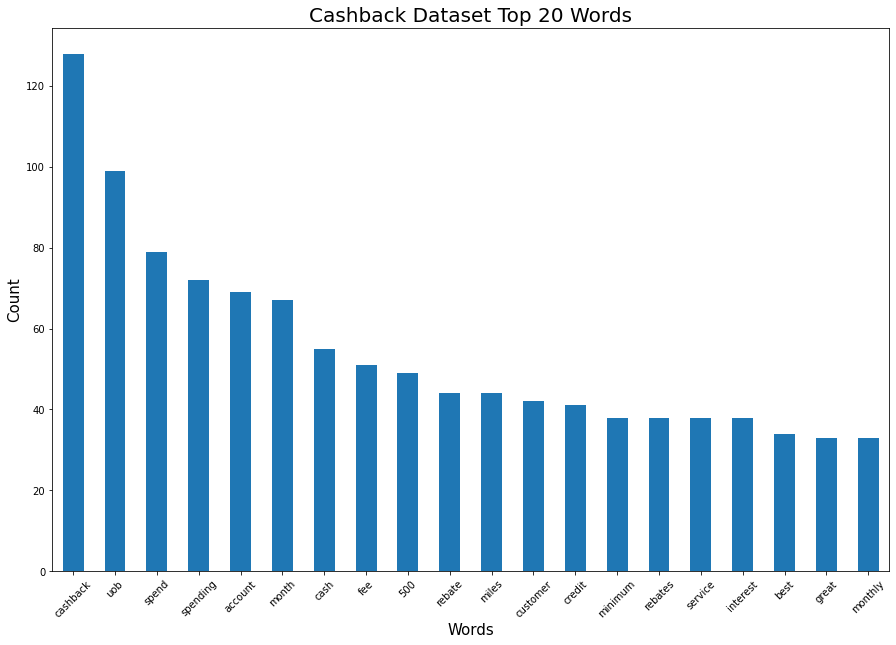

In [76]:
import matplotlib.pyplot as plt

# Convert the top word count to a dataframe
top_words_cashback = top_words(cashback_sparse_matrix_further, 20).to_frame()

# Plot the top 20 words in a bar chart
cashback_bar = top_words_cashback.plot(kind='bar', figsize=(15, 10), fontsize=10, width=0.5)

# Set the title, x & y labels and remove legend
cashback_bar.set_title('Cashback Dataset Top 20 Words', fontsize=20)
cashback_bar.get_legend().remove()
cashback_bar.set_ylabel('Count', fontsize=15)
cashback_bar.set_xlabel('Words', fontsize=15)
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [77]:
# Lemmatize the 'title and selftext' column in the perfumes_df_cleaned dataset
cashback_analyse_df['reviews_lemmatized'] = cashback_analyse_df['reviews_no_stop'].apply(
    lambda x: lemmatizing(x))

# Concatenate all the words in the 'title_and_selftext_lemmatized' column to string
cashback_analyse_df['reviews_string'] = cashback_analyse_df['reviews_lemmatized'].apply(
    lambda x: ' '.join(x))

# Create a mask for the word cloud
cashback_mask = np.array(Image.open('image/dollar.png'))

# Generate a word cloud
wc = WordCloud(background_color="white", colormap="tab10", max_font_size=150, mask = cashback_mask)

wcloud = wc.generate(' '.join(cashback_analyse_df['reviews_string']))

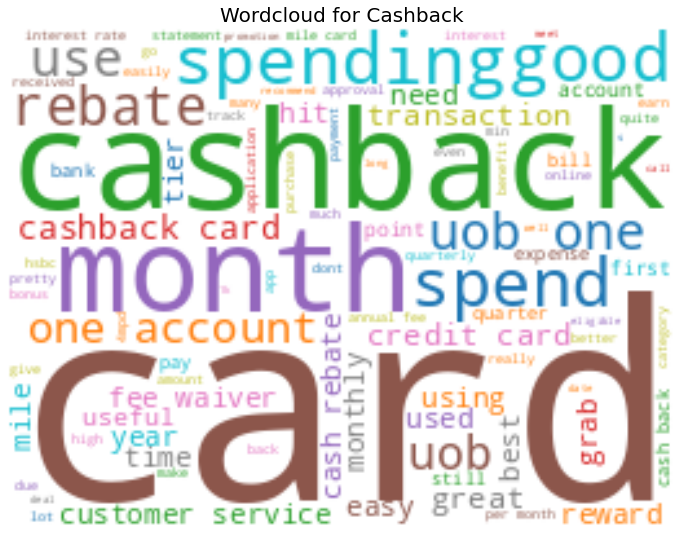

In [78]:
# Make figure to plot
plt.figure(figsize = (12,12))

# plot words
plt.imshow(wcloud, interpolation="bilinear")

# remove axes
plt.title("Wordcloud for Cashback", fontsize = 20)

# remove axes
plt.axis("off")

# save chart as png
plt.savefig('image/cashback_wordcloud.png', transparent = True, bbox_inches = 'tight')

# show the result
plt.show()

**2.4. Most Common Words in Air Miles dataset**

In [79]:
# Find the top 50 words in Air Miles dataset
print('Top 50 words in Air Miles dataset:')
print("")
print(top_words(miles_sparse_matrix, 50).to_string())

Top 50 words in Air Miles dataset:

mile           327
card           291
fee             79
expire          63
db              63
point           58
waiver          55
good            50
spend           45
get             43
per             42
use             41
spending        40
lounge          40
year            36
annual          36
travel          34
best            33
great           33
promotion       32
credit          32
one             31
using           29
dollar          28
customer        28
earn            25
dont            25
service         25
also            25
easy            24
online          23
transaction     23
rate            23
like            22
access          22
general         21
time            21
call            21
priority        21
better          20
free            20
reward          20
pas             20
bonus           18
never           18
citi            18
12              18
overseas        17
accumulate      17
really          17


Noted that there are further stopwords like spaces, '2', '1', etc that doesn't really make sense. As such we will remove these words from the `miles_analyse_df` dataset. 

From the top 50 words, we will try to identify and remove as many stop words as possible. After that, we will look at the revised top 20 words to make sure that all of the stopwords have been removed from the list.

**2.5. Remove Further Stopwords from the Air Miles Dataset**

In [80]:
# Define function to remove stop words
def remove_further_stopwords(tokenized_list, stopword_list):
    # Store in text only if word is not found in stopword i.e. it is not a stopword
    text = [word for word in tokenized_list if word not in stopword_list]
    return text

# List of additional stopwords to remove for Air Miles dataset
stopwords_miles = ['', 'credit', 'card', 'one', '1', '2', 'per', 'get', 'use', '3']

# Remove further stopwords from 'reviews_no_stop' column for Air Miles dataset
miles_analyse_df['reviews_no_stop_further'] = miles_analyse_df['reviews_no_stop'].apply(
    lambda x: remove_further_stopwords(x, stopwords_miles))

# Recreate the sparse matrix for Air Miles dataset after removing further stopwords
miles_sparse_matrix_further = sparsematrix_check(
    miles_analyse_df['reviews_no_stop_further'].apply(lambda x: ' '.join(x))
)

# Display top 20 words after removing further stopwords
print('Top 20 words in Air Miles dataset (After Further Stopword Removal):')
print(top_words(miles_sparse_matrix_further, 20).to_string())


Top 20 words in Air Miles dataset (After Further Stopword Removal):
miles       320
dbs          63
expire       63
fee          62
points       51
good         50
spend        45
spending     40
cards        37
annual       36
waiver       34
best         33
great        33
travel       32
lounge       32
using        29
customer     25
dont         25
also         25
earn         25


After removing further stopwords, the top 20 words seems to make more sense now. From my the looks of this. The most common topics seems to be about the miles, the minimum spending, fee waiver and services provided by the banks.

Now, let's visualise our above findings.

**2.6. Visualise our findings for the Air Miles Dataset**

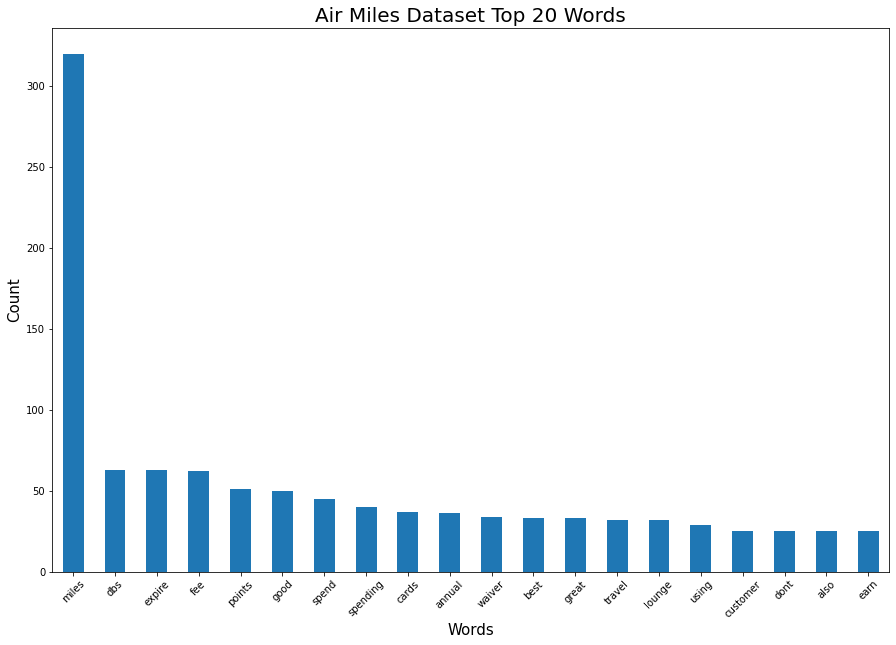

In [81]:
# Convert the top word count to a dataframe
top_words_miles = top_words(miles_sparse_matrix_further, 20).to_frame()

# Plot the top 20 words in a bar chart
miles_bar = top_words_miles.plot(kind='bar', figsize=(15, 10), fontsize=10, width=0.5)

# Set the title, x & y labels and remove legend
miles_bar.set_title('Air Miles Dataset Top 20 Words', fontsize=20)
miles_bar.get_legend().remove()
miles_bar.set_ylabel('Count', fontsize=15)
miles_bar.set_xlabel('Words', fontsize=15)
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [82]:
# Lemmatize the 'title and selftext' column in the perfumes_df_cleaned dataset
miles_analyse_df['reviews_lemmatized'] = miles_analyse_df['reviews_no_stop'].apply(
    lambda x: lemmatizing(x))

# Concatenate all the words in the 'title_and_selftext_lemmatized' column to string
miles_analyse_df['reviews_string'] = miles_analyse_df['reviews_lemmatized'].apply(
    lambda x: ' '.join(x))

# Create a mask for the word cloud
miles_mask = np.array(Image.open('image/plane.jpg'))

# Generate a word cloud
wc = WordCloud(background_color="white", colormap="tab10", max_font_size=150, mask = miles_mask)

wcloud = wc.generate(' '.join(miles_analyse_df['reviews_string']))

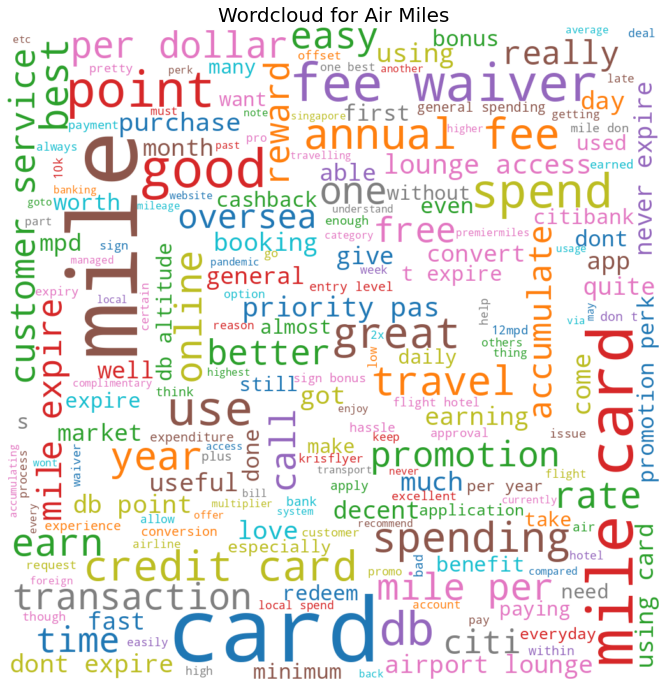

In [83]:
# Make figure to plot
plt.figure(figsize = (12,12))

# plot words
plt.imshow(wcloud, interpolation="bilinear")

# remove axes
plt.title("Wordcloud for Air Miles", fontsize = 20)

# remove axes
plt.axis("off")

# save chart as png
plt.savefig('image/miles_wordcloud.png', transparent = True, bbox_inches = 'tight')

# show the result
plt.show()

## Sentiment Analysis Using BERT

We have managed to identify the key card features that customers are looking out for. However, we do not know whether the discussions were of a positive or negative sentiment. As such, we will perform sentiment analysis on these reviews by using BERT.

Code to install `pytorch` and `huggingface` transformers:

In [37]:
# pip install torch torchvision torchaudio
# pip install transformers

We will make use of the pretrained model found on huggingface. [(source)](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment)

In [84]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment")

In [85]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [86]:
# Create a function to get the sentiment score
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors = 'pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [87]:
# Remove the 'Sentiment' and 'Sentiment Classification' columns
cashback_expand_df = cashback_expand_df.drop(['Sentiment', 'Sentiment_Classification'], axis=1)

# Display the DataFrame after removing the columns
display(cashback_expand_df.head())


,Card,Review,Review_cleaned,card_type,Review_tokenized,Review_no_stop,Review_lemmatized
0,UOB One Card,I have had my own story of crypto scams due to...,i have had my own story of crypto scams due to...,Cashback,"[i, have, had, my, own, story, of, crypto, sca...","[story, crypto, scams, due, referrals, site, l...","[story, crypto, scam, due, referral, site, los..."
1,UOB One Card,Good credit card to provide higher interest ra...,good credit card to provide higher interest ra...,Cashback,"[good, credit, card, to, provide, higher, inte...","[good, credit, card, provide, higher, interest...","[good, credit, card, provide, higher, interest..."
2,UOB One Card,Applied for this card years back along with on...,applied for this card years back along with on...,Cashback,"[applied, for, this, card, years, back, along,...","[applied, card, years, back, along, one, accou...","[applied, card, year, back, along, one, accoun..."
3,UOB One Card,Pair up this card with the UOB ONE Savings acc...,pair up this card with the uob one savings acc...,Cashback,"[pair, up, this, card, with, the, uob, one, sa...","[pair, card, uob, one, savings, account, maxim...","[pair, card, uob, one, saving, account, maximi..."
4,UOB One Card,The longest CC I have. It is a great card to u...,the longest cc i have it is a great card to us...,Cashback,"[the, longest, cc, i, have, it, is, a, great, ...","[longest, cc, great, card, use, use, min, 2k, ...","[longest, cc, great, card, use, use, min, 2k, ..."


In [88]:
cashback_expand_df['sentiment'] = cashback_expand_df['Review_cleaned'].apply(lambda x: sentiment_score(x))

# Display the dataset after the sentiment analysis
display(cashback_expand_df.head())

,Card,Review,Review_cleaned,card_type,Review_tokenized,Review_no_stop,Review_lemmatized,sentiment
0,UOB One Card,I have had my own story of crypto scams due to...,i have had my own story of crypto scams due to...,Cashback,"[i, have, had, my, own, story, of, crypto, sca...","[story, crypto, scams, due, referrals, site, l...","[story, crypto, scam, due, referral, site, los...",1
1,UOB One Card,Good credit card to provide higher interest ra...,good credit card to provide higher interest ra...,Cashback,"[good, credit, card, to, provide, higher, inte...","[good, credit, card, provide, higher, interest...","[good, credit, card, provide, higher, interest...",4
2,UOB One Card,Applied for this card years back along with on...,applied for this card years back along with on...,Cashback,"[applied, for, this, card, years, back, along,...","[applied, card, years, back, along, one, accou...","[applied, card, year, back, along, one, accoun...",5
3,UOB One Card,Pair up this card with the UOB ONE Savings acc...,pair up this card with the uob one savings acc...,Cashback,"[pair, up, this, card, with, the, uob, one, sa...","[pair, card, uob, one, savings, account, maxim...","[pair, card, uob, one, saving, account, maximi...",4
4,UOB One Card,The longest CC I have. It is a great card to u...,the longest cc i have it is a great card to us...,Cashback,"[the, longest, cc, i, have, it, is, a, great, ...","[longest, cc, great, card, use, use, min, 2k, ...","[longest, cc, great, card, use, use, min, 2k, ...",5


In [89]:
# Remove the 'Sentiment' and 'Sentiment Classification' columns
miles_expand_df = miles_expand_df.drop(['Sentiment', 'Sentiment_Classification'], axis=1)

# Display the DataFrame after removing the columns
display(miles_expand_df.head())


,Card,Review,Review_cleaned,card_type,Review_tokenized,Review_no_stop,Review_lemmatized
171,Citi PremierMiles Visa Card,[Fee Waivers]\nAnnual fee waiver was almost au...,fee waivers annual fee waiver was almost autom...,Air Miles,"[fee, waivers, annual, fee, waiver, was, almos...","[fee, waivers, annual, fee, waiver, almost, au...","[fee, waiver, annual, fee, waiver, almost, aut..."
172,Citi PremierMiles Visa Card,Although the fee waiver could actually be done...,although the fee waiver could actually be done...,Air Miles,"[although, the, fee, waiver, could, actually, ...","[although, fee, waiver, could, actually, done,...","[although, fee, waiver, could, actually, done,..."
173,Citi PremierMiles Visa Card,This is a good credit card for overseas travel...,this is a good credit card for overseas travel...,Air Miles,"[this, is, a, good, credit, card, for, oversea...","[good, credit, card, overseas, travelling, iss...","[good, credit, card, overseas, travelling, iss..."
174,Citi PremierMiles Visa Card,Good promotions and very easy to access my rew...,good promotions and very easy to access my rew...,Air Miles,"[good, promotions, and, very, easy, to, access...","[good, promotions, easy, access, rewards, when...","[good, promotion, easy, access, reward, whenev..."
175,Citi PremierMiles Visa Card,[Promotions and Perks]\nMiles never expires. T...,promotions and perks miles never expires they ...,Air Miles,"[promotions, and, perks, miles, never, expires...","[promotions, perks, miles, never, expires, att...","[promotion, perk, mile, never, expires, attain..."


In [90]:
# Perform sentiment analysis on the cashback dataset
miles_expand_df['sentiment'] = miles_expand_df['Review_cleaned'].apply(lambda x: sentiment_score(x))

# Display the dataset after the sentiment analysis
display(miles_expand_df.head())

,Card,Review,Review_cleaned,card_type,Review_tokenized,Review_no_stop,Review_lemmatized,sentiment
171,Citi PremierMiles Visa Card,[Fee Waivers]\nAnnual fee waiver was almost au...,fee waivers annual fee waiver was almost autom...,Air Miles,"[fee, waivers, annual, fee, waiver, was, almos...","[fee, waivers, annual, fee, waiver, almost, au...","[fee, waiver, annual, fee, waiver, almost, aut...",3
172,Citi PremierMiles Visa Card,Although the fee waiver could actually be done...,although the fee waiver could actually be done...,Air Miles,"[although, the, fee, waiver, could, actually, ...","[although, fee, waiver, could, actually, done,...","[although, fee, waiver, could, actually, done,...",3
173,Citi PremierMiles Visa Card,This is a good credit card for overseas travel...,this is a good credit card for overseas travel...,Air Miles,"[this, is, a, good, credit, card, for, oversea...","[good, credit, card, overseas, travelling, iss...","[good, credit, card, overseas, travelling, iss...",4
174,Citi PremierMiles Visa Card,Good promotions and very easy to access my rew...,good promotions and very easy to access my rew...,Air Miles,"[good, promotions, and, very, easy, to, access...","[good, promotions, easy, access, rewards, when...","[good, promotion, easy, access, reward, whenev...",5
175,Citi PremierMiles Visa Card,[Promotions and Perks]\nMiles never expires. T...,promotions and perks miles never expires they ...,Air Miles,"[promotions, and, perks, miles, never, expires...","[promotions, perks, miles, never, expires, att...","[promotion, perk, mile, never, expires, attain...",5


Now that we have obtained an analysis of the reviews, we will be able to know which card has the best reviews and which cards have the worst. In order to make comparisons between 2 cards, we will need to calculate a aggregated score for these cards. In this case, we will use a benchmarking tool called the 'Net Promoter Score' (NPS).

In [91]:
# Combine cashback_expand_df and miles_expand_df into one dataset
combined_expand_df = pd.concat([cashback_expand_df, miles_expand_df], ignore_index=True)

# Display the combined dataset
display(combined_expand_df.head())


,Card,Review,Review_cleaned,card_type,Review_tokenized,Review_no_stop,Review_lemmatized,sentiment
0,UOB One Card,I have had my own story of crypto scams due to...,i have had my own story of crypto scams due to...,Cashback,"[i, have, had, my, own, story, of, crypto, sca...","[story, crypto, scams, due, referrals, site, l...","[story, crypto, scam, due, referral, site, los...",1
1,UOB One Card,Good credit card to provide higher interest ra...,good credit card to provide higher interest ra...,Cashback,"[good, credit, card, to, provide, higher, inte...","[good, credit, card, provide, higher, interest...","[good, credit, card, provide, higher, interest...",4
2,UOB One Card,Applied for this card years back along with on...,applied for this card years back along with on...,Cashback,"[applied, for, this, card, years, back, along,...","[applied, card, years, back, along, one, accou...","[applied, card, year, back, along, one, accoun...",5
3,UOB One Card,Pair up this card with the UOB ONE Savings acc...,pair up this card with the uob one savings acc...,Cashback,"[pair, up, this, card, with, the, uob, one, sa...","[pair, card, uob, one, savings, account, maxim...","[pair, card, uob, one, saving, account, maximi...",4
4,UOB One Card,The longest CC I have. It is a great card to u...,the longest cc i have it is a great card to us...,Cashback,"[the, longest, cc, i, have, it, is, a, great, ...","[longest, cc, great, card, use, use, min, 2k, ...","[longest, cc, great, card, use, use, min, 2k, ...",5


**Net Promoter Score**

NPS is a benchmarking tool for customer satisfaction. The NPS method gives insights about customer loyalty by measuring customers’ willingness to recommend a business to a friend or acquaintance.

NPS differs from other related benchmarks, such as the customer satisfaction score, by indicating a customer’s general sentiment about a brand as opposed to their opinion on particular interactions or purchases. Because of this, it crops up frequently in discussions about customer experience.

In addition, net promoter score is a standard benchmark used by companies worldwide. This makes it a good way for businesses to gauge their performance as compared to their competitors. [(source)](https://www.salesforce.com/eu/learning-centre/customer-service/calculate-net-promoter-score/#:~:text=Net%20promoter%20score%20helps%20businesses,revenue%20through%20referrals%20and%20upsells.)

Usually, the NPS is calculated on a scale of 1 - 10, with score 0-6 being classified as 'Detractors', 7-8 being classified as 'Passives' and 9-10 being classified as 'Promoters'. To calculate the net promoter score, the percentage of detractors is simply deducted from from the percentage of promoters. The worst possible score - i.e., the score that would be achieved if every customer was a detractor, is -100. The best is 100. [(source)](https://www.salesforce.com/eu/learning-centre/customer-service/calculate-net-promoter-score/#:~:text=Net%20promoter%20score%20helps%20businesses,revenue%20through%20referrals%20and%20upsells.) Any score above 0 is considered good, whilst any NPS score over +50 is considered excellent. Organizations that score over the +70 mark will be providing the best customer experience.[(source)](https://kwiksurveys.com/blog/feedback/net-promoter-score-how-to-calculate-nps)

However in our case, sentiment analysis is being performed on a scale of 1-5, thus we will 1-3 will be classified as 'Detractors', 4 will be classified as 'Passives' and 5 will be classified as 'Promoters.

**1. Net Promoter Score for Cashback cards**

In [92]:
# Save all the cashback cards into a list using the correct column name
cashback_names = cashback_expand_df['Card'].unique()

# Set the scores for promoters, passives, and detractors
Promoters = [5]
Passives = [4]
Detractors = [1, 2, 3]

# Create a dictionary to store the card names and the NPS
cashback_cards_nps = {}

for card in cashback_names:
    # Filter dataset for the individual cards
    individual_card = cashback_expand_df[cashback_expand_df['Card'] == card]
    
    # Calculate the total number of promoters and detractors
    card_promoters = round(individual_card[individual_card['sentiment'].isin(Promoters)].shape[0] / individual_card.shape[0] * 100, 0)
    card_detractors = round(individual_card[individual_card['sentiment'].isin(Detractors)].shape[0] / individual_card.shape[0] * 100, 0)
    
    # Calculate the NPS
    card_nps = card_promoters - card_detractors
    
    # Save the NPS in a dictionary
    cashback_cards_nps[card] = {}
    cashback_cards_nps[card]['no_of_reviews'] = individual_card.shape[0]
    cashback_cards_nps[card]['net_promoter_score'] = card_nps

# Store the results in a dataframe
cashback_cards_nps_df = pd.DataFrame.from_dict(cashback_cards_nps, orient='index')

# Display the NPS results
display(cashback_cards_nps_df.head())


,no_of_reviews,net_promoter_score
UOB One Card,171,-10.0
UOB Ladys Card,18,-45.0
HSBC Revolution Credit Card,55,-28.0


Let's take a look at the findings. We will sort the scores by the Net Promoter Score followed by the number of reviews. 

**1.1. Cashback cards with the highest NPS scores**

In [93]:
# Sort the dataset by net promoter score followed by the total number of reviews
display(cashback_cards_nps_df.sort_values(['net_promoter_score', 'no_of_reviews'], ascending = [False, False]).head(20))

,no_of_reviews,net_promoter_score
UOB One Card,171,-10.0
HSBC Revolution Credit Card,55,-28.0
UOB Ladys Card,18,-45.0


Seems like there are a few cards with a net promoter score of 100 but there is only 1 review for these cards. If we filter out these cards, the top card will be the OCBC Plus Visa Card followed by the Standard Chartered Unlimited Cashback Credit Card.

**1.2. Cashback cards with the lowest NPS scores**

Let's take a look at the cards that has the lowest NPS.

In [94]:
# Sort the dataset by net promoter score followed by the total number of reviews
display(cashback_cards_nps_df.sort_values(['net_promoter_score', 'no_of_reviews'], ascending = [True, False]).head(20))

,no_of_reviews,net_promoter_score
UOB Ladys Card,18,-45.0
HSBC Revolution Credit Card,55,-28.0
UOB One Card,171,-10.0


By looking at this, the OCBC Frank Credit Card has the worst Net Promoter scre followed by the Citi Cash Back Plus Card. Based on the above, we have noted tha there are quite a lot of credit cards that have very little reviews. Thus, we will exclude the cards that have less than 5 reviews when we make the recommendations later.

**2. Net Promoter Scores for miles card**

In [95]:
# Save all the miles cards into a list
miles_names = miles_expand_df['Card'].unique()

# Set the scores for promoters, passives and detractors
Promoters = [5]
Passives = [4]
Detractors = [1,2,3]

# Create a dictionary to store the card names and the NPS
miles_cards_nps = {}

for cards in miles_names:
    # Filter dataset for the individual cards
    individual_card = miles_expand_df[miles_expand_df['Card']== cards]
    
    # Calculate the total number of promoters and detractors
    card_promoters = round(individual_card[individual_card['sentiment'].isin(Promoters)].shape[0]/individual_card.shape[0]*100,0)
    card_detractors = round(individual_card[individual_card['sentiment'].isin(Detractors)].shape[0]/individual_card.shape[0]*100,0)
    
    # Calculate the NPS
    card_nps = card_promoters - card_detractors
    
    # Save the NPS in a dictionary
    miles_cards_nps[cards]={}
    miles_cards_nps[cards]['no_of_reviews'] = individual_card.shape[0]
    miles_cards_nps[cards]['net_promoter_score'] = card_nps
    
# Store the results in a dataframe
miles_cards_nps_df = pd.DataFrame.from_dict(miles_cards_nps, orient = 'index')
display(miles_cards_nps_df.head())

,no_of_reviews,net_promoter_score
Citi PremierMiles Visa Card,76,-23.0
DBS Altitude Visa Signature Card,107,16.0


Let's take a look at the findings. We will sort the scores by the Net Promoter Score followed by the number of reviews.

**2.1. Air Miles cards with the highest NPS scores**

In [96]:
# Sort the dataset by net promoter score followed by the total number of reviews
display(miles_cards_nps_df.sort_values(['net_promoter_score', 'no_of_reviews'], ascending = [False, False]).head(20))

,no_of_reviews,net_promoter_score
DBS Altitude Visa Signature Card,107,16.0
Citi PremierMiles Visa Card,76,-23.0


Based on the above, the Citibank Rewards Credit Card has best NPS followed by the UOB  Pri Miles VIsa Card and the DBS Womans World Card. Let's look at the cards with the lowest NPS scores.

**2.2. Air Miles cards with the lowest NPS scores**

In [97]:
# Sort the dataset by net promoter score followed by the total number of reviews
display(miles_cards_nps_df.sort_values(['net_promoter_score', 'no_of_reviews'], ascending = [True, False]).head(20))

,no_of_reviews,net_promoter_score
Citi PremierMiles Visa Card,76,-23.0
DBS Altitude Visa Signature Card,107,16.0


The Amex Capitacard has the lowest possible score of -100, but there were only 2 reviews. This means that the two users who had left the review would most probably have a bad experience using the cards. The card with the next worst NPS score is the Citi Premiermiles Visa Card followed by the OCBC 90 Degrees N Mastercard. Similarly, we will exclude the cards that have less than 5 reviews when we make our recommendations.

Now that we have completed the EDA analysis and calculated the Net Promoter Scores for the cards, we will start to build our credit card recommender.

**3. Export Datasets**

In [98]:
cashback_expand_df.to_csv('dataset/2.cashback_expand_df.csv')
miles_expand_df.to_csv('dataset/2.miles_expand_df.csv')
combined_expand_df.to_csv('dataset/2.combined_expand_df.csv')
miles_cards_nps_df.to_csv('dataset/2.miles_cards_nps_df.csv')
cashback_cards_nps_df.to_csv('dataset/2.cashback_cards_nps_df.csv')
cashback_analyse_df.to_csv('dataset/2.cashback_analyse_df.csv')
miles_analyse_df.to_csv('dataset/2.miles_analyse_df.csv')


We will continue the rest of the analysis in a separate workbook. Please refer to **"3. Modelling"** for the portion on modelling.